In [6]:
import os
import sys
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem, RDLogger
import sqlite3
from tqdm import tqdm
import matplotlib.pyplot as plt

# Suppress RDKit warnings for cleaner output during generation checks
RDLogger.DisableLog('rdApp.*')

# =========================================
# CONFIGURATION (SIMPLIFIED & TUNED)
# =========================================
class Config:
    # --- System & Data Paths ---
    CHEMPL_DB_PATH = 'DL_ENDSEM__DATASET/chembl_35/chembl_35_sqlite/chembl_35.db'
    MODEL_DIR = 'models_simplified_v2' # New dir for v2 run

    # --- Model Hyperparameters (SCALED DOWN) ---
    MAX_ATOMS = 9
    ATOM_LIST = ['C', 'N', 'O', 'F', 'S', 'Cl'] 
    NUM_ATOM_TYPES = len(ATOM_LIST) + 1 
    
    BOND_TYPES = [Chem.rdchem.BondType.ZERO,
                  Chem.rdchem.BondType.SINGLE,
                  Chem.rdchem.BondType.DOUBLE,
                  Chem.rdchem.BondType.TRIPLE,
                  Chem.rdchem.BondType.AROMATIC]
    NUM_BOND_TYPES = len(BOND_TYPES)

    LATENT_DIM = 128
    BATCH_SIZE = 64
    LR_G = 1e-4
    LR_D = 1e-4
    LAMBDA_GP = 10
    N_CRITIC = 5
    NUM_EPOCHS = 500   # Set to 500
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SAVE_EVERY = 50    # Save every 50 epochs
    RESUME_EPOCH = None # <-- MAKE SURE THIS IS NONE TO START SCRATCH

print(f"Running on device: {Config.DEVICE}")

# =========================================
# DATA UTILS
# =========================================
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    num_atoms = mol.GetNumAtoms()
    if num_atoms > Config.MAX_ATOMS or num_atoms < 2: return None

    X = np.zeros((Config.MAX_ATOMS, Config.NUM_ATOM_TYPES), dtype=np.float32)
    for i, atom in enumerate(mol.GetAtoms()):
        sym = atom.GetSymbol()
        if sym in Config.ATOM_LIST: X[i, Config.ATOM_LIST.index(sym)] = 1.0
        else: return None 
    for i in range(num_atoms, Config.MAX_ATOMS): X[i, -1] = 1.0

    A = np.zeros((Config.MAX_ATOMS, Config.MAX_ATOMS, Config.NUM_BOND_TYPES), dtype=np.float32)
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        b_type = bond.GetBondType()
        try:
            ch_idx = Config.BOND_TYPES.index(b_type)
            A[i, j, ch_idx] = A[j, i, ch_idx] = 1.0
        except ValueError: continue
    for i in range(Config.MAX_ATOMS):
        for j in range(Config.MAX_ATOMS):
            if np.sum(A[i,j,:]) == 0: A[i,j,0] = 1.0
    return X, A

def graphs_to_mols(node_X, adj_A, hard=True):
    mols = []
    if hard:
        if isinstance(node_X, torch.Tensor): node_X = torch.argmax(node_X, dim=-1).detach().cpu().numpy()
        if isinstance(adj_A, torch.Tensor): adj_A = torch.argmax(adj_A, dim=-1).detach().cpu().numpy()

    for b in range(node_X.shape[0]):
        mol = Chem.RWMol()
        atom_indices = []
        for i in range(Config.MAX_ATOMS):
            atom_type = node_X[b, i]
            if atom_type == len(Config.ATOM_LIST): continue
            atom_indices.append(mol.AddAtom(Chem.Atom(Config.ATOM_LIST[atom_type])))
        for i in range(len(atom_indices)):
            for j in range(i + 1, len(atom_indices)):
                bond_idx = adj_A[b, i, j]
                if bond_idx != 0:
                    try: mol.AddBond(atom_indices[i], atom_indices[j], Config.BOND_TYPES[bond_idx])
                    except: pass
        try:
            mol = mol.GetMol()
            Chem.SanitizeMol(mol)
            mols.append(mol)
        except: mols.append(None)
    return mols

# =========================================
# DATASET
# =========================================
class MoleculeDataset(Dataset):
    def __init__(self):
        self.data = []
        smiles_list = []
        if os.path.exists(Config.CHEMPL_DB_PATH):
            print(f"Connecting to DB at {Config.CHEMPL_DB_PATH}...")
            try:
                conn = sqlite3.connect(Config.CHEMPL_DB_PATH)
                cursor = conn.cursor()
                print("Querying for small molecule candidates...")
                cursor.execute("SELECT canonical_smiles FROM compound_structures WHERE length(canonical_smiles) < 50 LIMIT 200000")
                smiles_list = [row[0] for row in cursor.fetchall()]
                conn.close()
            except Exception as e: print(f"DB Error: {e}")

        print(f"Filtering for molecules with {Config.MAX_ATOMS} atoms or less...")
        np.random.shuffle(smiles_list)
        for s in tqdm(smiles_list):
            res = smiles_to_graph(s)
            if res is not None: self.data.append(res)
            if len(self.data) >= 20000: break 
        print(f"Training on {len(self.data)} valid small graphs.")

    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        X, A = self.data[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(A, dtype=torch.float32)

# =========================================
# MODELS
# =========================================
class GraphTransformerLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, adj_channels):
        super().__init__()
        self.embed_dim, self.num_heads, self.head_dim = embed_dim, num_heads, embed_dim // num_heads
        self.q_proj, self.k_proj, self.v_proj = nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim)
        self.out_proj, self.adj_proj = nn.Linear(embed_dim, embed_dim), nn.Linear(adj_channels, num_heads)
    def forward(self, x, adj):
        B, N, _ = x.shape
        Q, K, V = [proj(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2) for proj in (self.q_proj, self.k_proj, self.v_proj)]
        attn = (Q @ K.transpose(-2, -1)) / np.sqrt(self.head_dim) + self.adj_proj(adj).permute(0, 3, 1, 2)
        return self.out_proj((F.softmax(attn, dim=-1) @ V).transpose(1, 2).reshape(B, N, self.embed_dim)) + x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(Config.LATENT_DIM, 128)
        self.fc_nodes = nn.Linear(128, Config.MAX_ATOMS * Config.NUM_ATOM_TYPES)
        self.fc_adj = nn.Linear(128, Config.MAX_ATOMS * Config.MAX_ATOMS * Config.NUM_BOND_TYPES)
        for m in self.modules():
            if isinstance(m, nn.Linear): nn.init.normal_(m.weight, 0, 0.02)

    def forward(self, z, temperature=1.0):
        h = F.leaky_relu(self.fc(z), 0.2)
        nodes = F.gumbel_softmax(self.fc_nodes(h).view(-1, Config.MAX_ATOMS, Config.NUM_ATOM_TYPES), tau=temperature, hard=False, dim=-1)
        adj = self.fc_adj(h).view(-1, Config.MAX_ATOMS, Config.MAX_ATOMS, Config.NUM_BOND_TYPES)
        return nodes, F.gumbel_softmax((adj + adj.permute(0, 2, 1, 3)) / 2.0, tau=temperature, hard=False, dim=-1)

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Linear(Config.NUM_ATOM_TYPES, 64)
        self.gt1, self.gt2 = GraphTransformerLayer(64, 4, Config.NUM_BOND_TYPES), GraphTransformerLayer(64, 4, Config.NUM_BOND_TYPES)
        self.out = nn.Sequential(nn.Linear(64, 64), nn.LeakyReLU(0.2), nn.Linear(64, 1))
    def forward(self, x, adj):
        return self.out(torch.mean(self.gt2(self.gt1(self.embed(x), adj), adj), dim=1))

# =========================================
# TRAINING & PLOTTING
# =========================================
def compute_gp(D, r_n, r_a, f_n, f_a):
    alpha = torch.rand(r_n.size(0), 1, 1, 1, device=Config.DEVICE)
    inter_n = (alpha.squeeze(-1) * r_n + (1 - alpha.squeeze(-1)) * f_n).requires_grad_(True)
    inter_a = (alpha * r_a + (1 - alpha) * f_a).requires_grad_(True)
    d_inter = D(inter_n, inter_a)
    grads = torch.autograd.grad(d_inter, [inter_n, inter_a], torch.ones_like(d_inter), create_graph=True, retain_graph=True)
    return ((torch.cat([g.reshape(r_n.size(0), -1) for g in grads], dim=1).norm(2, dim=1) - 1) ** 2).mean()

def load_checkpoint(epoch, gen, crit=None):
    g_path = os.path.join(Config.MODEL_DIR, f'g_{epoch}.pth')
    if not os.path.exists(g_path): return False
    gen.load_state_dict(torch.load(g_path, map_location=Config.DEVICE))
    if crit: crit.load_state_dict(torch.load(os.path.join(Config.MODEL_DIR, f'c_{epoch}.pth'), map_location=Config.DEVICE))
    return True

def evaluate(epoch, gen=None):
    if gen is None:
        gen = Generator().to(Config.DEVICE)
        if not load_checkpoint(epoch, gen):
            print(f"Evaluate failed: Checkpoint g_{epoch}.pth not found.")
            return
    gen.eval()
    valid_mols = []
    with torch.no_grad():
        for _ in range(5):
             mols = graphs_to_mols(*gen(torch.randn(100, Config.LATENT_DIM, device=Config.DEVICE), temperature=0.1))
             valid_mols.extend([Chem.MolToSmiles(m) for m in mols if m])
    unique = set(valid_mols)
    print(f"\nEp {epoch} Results (N=500) | Valid: {(len(valid_mols)/500)*100:.1f}% | Unique: {len(unique)}")
    if unique: print(f"Samples: {list(unique)[:3]}")
    print("-" * 50)
    gen.train() # Set back to train mode

def plot_training_history():
    log_path = os.path.join(Config.MODEL_DIR, 'training_log.csv')
    if not os.path.exists(log_path):
        print(f"Plot Error: Log file not found at {log_path}")
        return
    try:
        df = pd.read_csv(log_path)
        window_size = max(10, len(df) // 100)
        df['D_rolling'] = df['D_loss'].rolling(window=window_size).mean()
        df['G_rolling'] = df['G_loss'].rolling(window=window_size).mean()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(df['D_loss'], alpha=0.2, label='Raw D Loss', color='blue')
        plt.plot(df['D_rolling'], label=f'Smoothed D Loss (win={window_size})', color='navy')
        plt.title('Discriminator Loss')
        plt.xlabel('Iterations'); plt.ylabel('Loss'); plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.plot(df['G_loss'], alpha=0.2, label='Raw G Loss', color='orange')
        plt.plot(df['G_rolling'], label=f'Smoothed G Loss (win={window_size})', color='red')
        plt.title('Generator Loss')
        plt.xlabel('Iterations'); plt.ylabel('Loss'); plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        save_path = os.path.join(Config.MODEL_DIR, 'training_history.png')
        plt.savefig(save_path)
        plt.show() # Display plot in notebook
        print(f"Plot saved to {save_path}")
    except Exception as e: print(f"Could not plot history: {e}")

def train():
    os.makedirs(Config.MODEL_DIR, exist_ok=True)
    log_path = os.path.join(Config.MODEL_DIR, 'training_log.csv')
    
    dataset = MoleculeDataset()
    if len(dataset) < Config.BATCH_SIZE: return
    loader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=True, drop_last=True)
    gen, crit = Generator().to(Config.DEVICE), Critic().to(Config.DEVICE)
    opt_G, opt_D = optim.Adam(gen.parameters(), lr=Config.LR_G, betas=(0., 0.9)), optim.Adam(crit.parameters(), lr=Config.LR_D, betas=(0., 0.9))

    start_epoch = 0
    if Config.RESUME_EPOCH and load_checkpoint(Config.RESUME_EPOCH, gen, crit): 
        start_epoch = Config.RESUME_EPOCH
        print(f"Resuming from epoch {start_epoch}")
    
    # <-- THIS IS THE KEY CHANGE: Always create header if file doesn't exist
    if not os.path.exists(log_path) or start_epoch == 0:
        with open(log_path, 'w') as f: f.write('Epoch,Batch,D_loss,G_loss\n')

    for epoch in range(start_epoch, Config.NUM_EPOCHS):
        temp = max(0.5, 2.0 - 1.5 * (epoch / Config.NUM_EPOCHS))
        pbar = tqdm(loader, desc=f"Ep {epoch+1}/{Config.NUM_EPOCHS} [T={temp:.2f}]")
        for i, (r_n, r_a) in enumerate(pbar):
            r_n, r_a = r_n.to(Config.DEVICE), r_a.to(Config.DEVICE)
            r_n_noisy, r_a_noisy = r_n + 0.05 * torch.randn_like(r_n), r_a + 0.05 * torch.randn_like(r_a)

            for _ in range(Config.N_CRITIC):
                crit.zero_grad()
                f_n, f_a = gen(torch.randn(r_n.size(0), Config.LATENT_DIM, device=Config.DEVICE), temperature=temp)
                d_loss = crit(f_n.detach(), f_a.detach()).mean() - crit(r_n_noisy, r_a_noisy).mean() + Config.LAMBDA_GP * compute_gp(crit, r_n, r_a, f_n.detach(), f_a.detach())
                d_loss.backward()
                opt_D.step()
            
            gen.zero_grad()
            g_loss = -crit(*gen(torch.randn(r_n.size(0), Config.LATENT_DIM, device=Config.DEVICE), temperature=temp)).mean()
            g_loss.backward()
            opt_G.step()
            pbar.set_postfix({'D': d_loss.item(), 'G': g_loss.item()})
            
            with open(log_path, 'a') as f: f.write(f'{epoch+1},{i},{d_loss.item()},{g_loss.item()}\n')

        if (epoch+1) % Config.SAVE_EVERY == 0:
            torch.save(gen.state_dict(), f"{Config.MODEL_DIR}/g_{epoch+1}.pth")
            torch.save(crit.state_dict(), f"{Config.MODEL_DIR}/c_{epoch+1}.pth")
            evaluate(epoch+1, gen)

    # After all training is done, plot the final history
    plot_training_history()

# =========================================
# Main Execution
# =========================================
if __name__ == '__main__':
    # This logic allows running from a notebook cell
    # To evaluate, you'd run `evaluate(epoch_num)` in a cell
    # To plot, you'd run `plot_training_history()` in a cell
    # To train, you'd run `train()` in a cell
    
    # Check for command-line arguments (for .py script)
    if len(sys.argv) > 2 and sys.argv[1] == 'eval': 
        evaluate(int(sys.argv[2]))
    elif len(sys.argv) > 1 and sys.argv[1] == 'plot': 
        plot_training_history()
    else:
        # Default action: train (this is what happens in a notebook)
        train()

Running on device: cuda
Connecting to DB at DL_ENDSEM__DATASET/chembl_35/chembl_35_sqlite/chembl_35.db...
Querying for small molecule candidates...
Filtering for molecules with 9 atoms or less...


100%|██████████| 200000/200000 [00:18<00:00, 10546.23it/s]


Training on 1431 valid small graphs.


Ep 50/500 [T=1.85]: 100%|██████████| 22/22 [00:01<00:00, 12.80it/s, D=-1.58, G=1.23] 



Ep 50 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 100/500 [T=1.70]: 100%|██████████| 22/22 [00:01<00:00, 13.25it/s, D=-1.01, G=1.22]



Ep 100 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 150/500 [T=1.55]: 100%|██████████| 22/22 [00:01<00:00, 13.75it/s, D=-0.969, G=2.34]



Ep 150 Results (N=500) | Valid: 0.6% | Unique: 3
Samples: ['C=S12(O)C3C1N32', 'OC1=CO1', 'CC1CC1.O']
--------------------------------------------------


Ep 200/500 [T=1.40]: 100%|██████████| 22/22 [00:01<00:00, 13.95it/s, D=-0.984, G=1.5] 



Ep 200 Results (N=500) | Valid: 4.6% | Unique: 21
Samples: ['C.CCC', 'C.CC(C)C', 'C.SC1=CC1']
--------------------------------------------------


Ep 250/500 [T=1.25]: 100%|██████████| 22/22 [00:01<00:00, 13.56it/s, D=-1.2, G=0.58]   



Ep 250 Results (N=500) | Valid: 2.6% | Unique: 8
Samples: ['C.CC12C=C1N2', 'CN1C2=CC21C', 'C.CCN']
--------------------------------------------------


Ep 300/500 [T=1.10]: 100%|██████████| 22/22 [00:01<00:00, 13.80it/s, D=-12.1, G=7.63]



Ep 300 Results (N=500) | Valid: 14.0% | Unique: 46
Samples: ['CC12C=[SH]1(C)N2.O', 'CC12C3=[SH]1(C)N2C3', 'C.CC12C=[SH]1(C)C2']
--------------------------------------------------


Ep 350/500 [T=0.95]: 100%|██████████| 22/22 [00:01<00:00, 13.49it/s, D=-70.1, G=23.7]



Ep 350 Results (N=500) | Valid: 1.2% | Unique: 6
Samples: ['CC1C2(C)C3(N)CC132', 'CC1CCN1', 'CC12CC13C14C[SH]2C13C4']
--------------------------------------------------


Ep 361/500 [T=0.92]:  77%|███████▋  | 17/22 [00:01<00:00, 12.98it/s, D=-107, G=28]   


KeyboardInterrupt: 

In [8]:
import pandas as pd
from tqdm import tqdm

def generate_final_dataset(best_epoch=260, num_samples=1000):
    gen = Generator().to(Config.DEVICE)
    if not load_checkpoint(best_epoch, gen):
        print(f"Could not load checkpoint for epoch {best_epoch}")
        return

    gen.eval()
    valid_smiles = []
    print(f"Generating {num_samples} molecules from best epoch {best_epoch}...")
    
    with torch.no_grad():
        # Generate in batches of 100 until we have enough
        pbar = tqdm(total=num_samples)
        while len(valid_smiles) < num_samples:
            z = torch.randn(100, Config.LATENT_DIM, device=Config.DEVICE)
            # Use a slightly lower temperature (0.8) for better quality
            mols = graphs_to_mols(*gen(z, temperature=0.8))
            
            for m in mols:
                if m:
                    try:
                        smi = Chem.MolToSmiles(m)
                        # Filter out disconnected fragments (contain '.')
                        if '.' not in smi and len(smi) > 0:
                            valid_smiles.append(smi)
                            pbar.update(1)
                    except:
                        pass
            
            # Stop if we have enough
            if len(valid_smiles) >= num_samples:
                break
        pbar.close()

    # Save to CSV
    unique_smiles = sorted(list(set(valid_smiles)))
    df = pd.DataFrame({'smiles': unique_smiles})
    output_file = os.path.join(Config.MODEL_DIR, f'final_generated_molecules_ep{best_epoch}.csv')
    df.to_csv(output_file, index=False)
    
    print(f"\nSUCCESS! Saved {len(unique_smiles)} unique, valid, connected molecules to:")
    print(output_file)
    print("\nFirst 10 generated molecules:")
    for s in unique_smiles[:10]:
        print(s)

# Run extraction on your best epoch
generate_final_dataset(best_epoch=250, num_samples=1000)

Generating 1000 molecules from best epoch 250...


100%|██████████| 1000/1000 [00:05<00:00, 171.90it/s]



SUCCESS! Saved 218 unique, valid, connected molecules to:
models_simplified_v2\final_generated_molecules_ep250.csv

First 10 generated molecules:
C#CC(N)Cl
C#CNO
C1=C2C3CCC123
C1=C2N3CCC123
C1=C2NC12
C1=CCN=1
C1C2=C1N2
C1C2NC12
C1CNC1
C1COC1


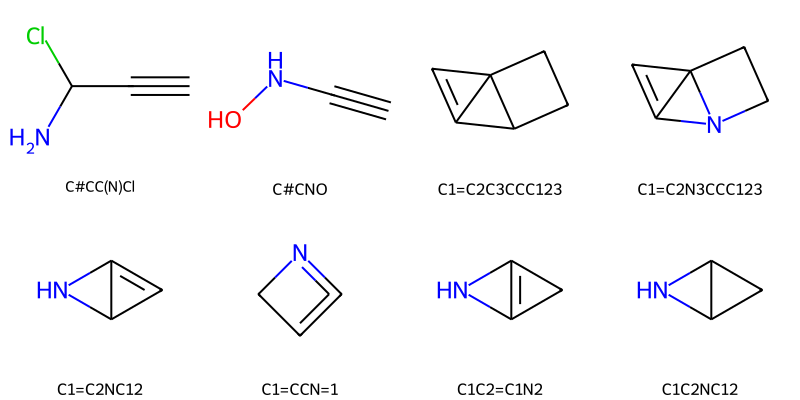

In [9]:
from rdkit.Chem import Draw
df = pd.read_csv(os.path.join(Config.MODEL_DIR, 'final_generated_molecules_ep250.csv'))
mols = [Chem.MolFromSmiles(s) for s in df['smiles'][:8]]
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=[s[:20] for s in df['smiles'][:8]])
img

Loading molecules from models_simplified_v2\final_generated_molecules_ep250.csv...
Calculating physicochemical properties...

--- Summary Statistics of Generated Molecules ---
            MW     LogP      QED     TPSA      HBD      HBA
count  218.000  218.000  218.000  218.000  218.000  218.000
mean    95.446    0.362    0.381   22.941    1.055    1.427
std     29.545    0.690    0.069   14.781    0.801    0.710
min     45.085   -1.778    0.200    0.000    0.000    0.000
25%     73.139   -0.106    0.346   12.360    1.000    1.000
50%     90.844    0.457    0.389   21.940    1.000    1.000
75%    115.939    0.775    0.428   29.083    2.000    2.000
max    164.299    2.052    0.563   72.270    3.000    4.000

Plotting property distributions...


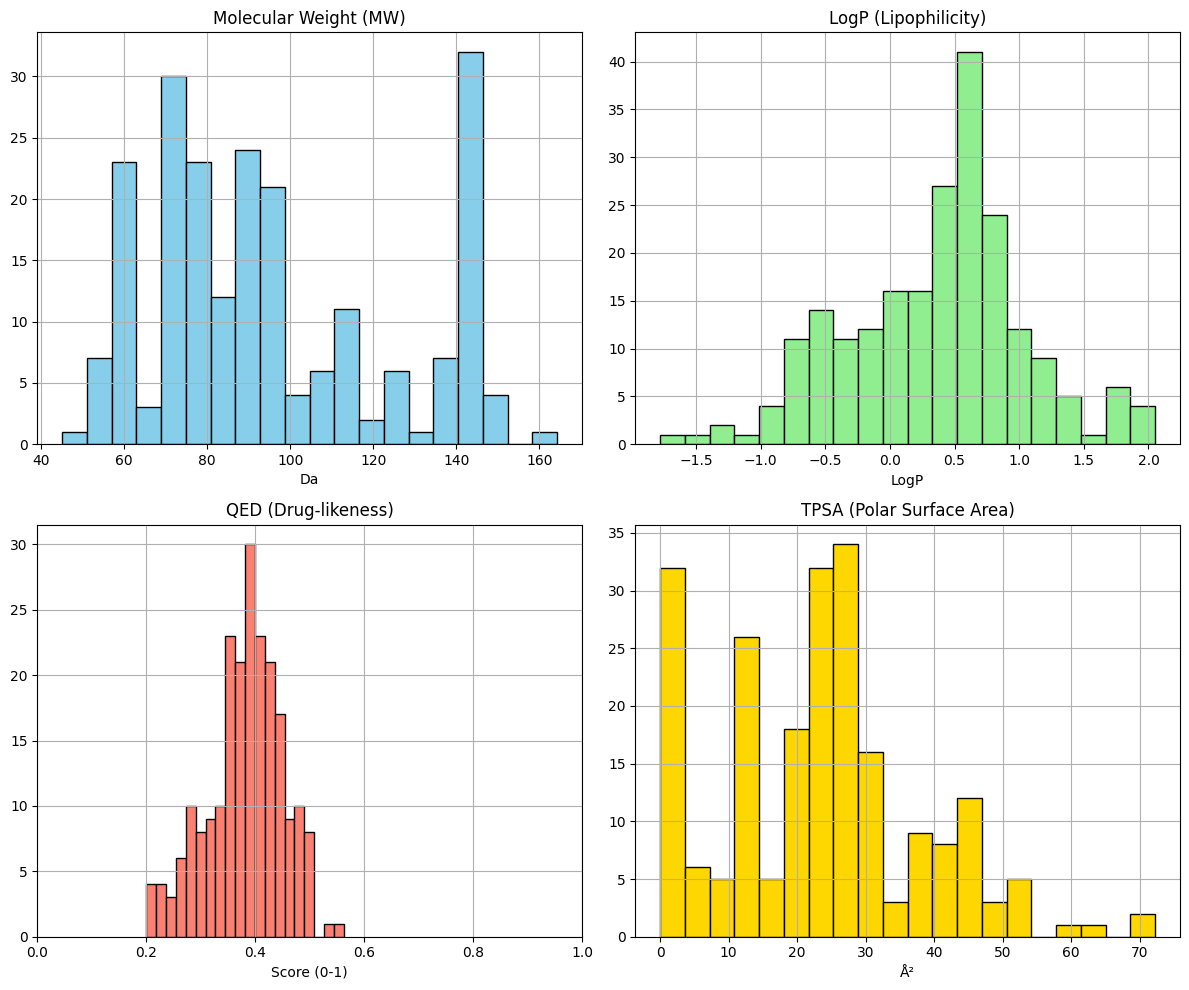


Visualizing molecules with highest QED (most drug-like)...


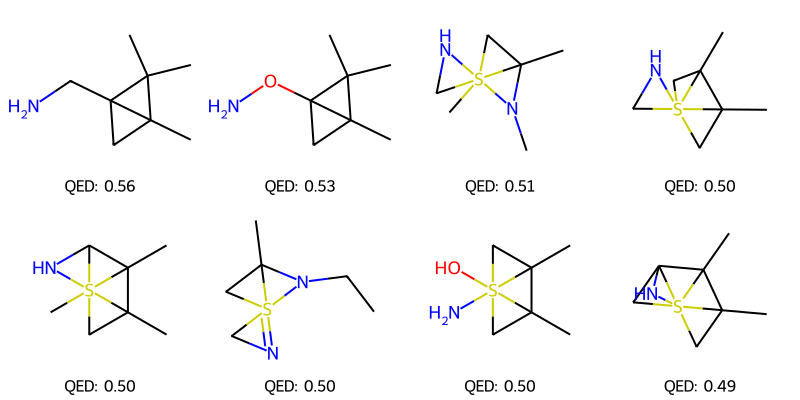

In [10]:
import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, RDConfig
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import sys

# Add RDKit contrib path for SA score if needed, though often it's built-in or requires a separate script.
# For simplicity, we'll stick to standard descriptors first.

def analyze_generated_molecules(csv_path):
    if not os.path.exists(csv_path):
        print(f"Error: CSV file not found at {csv_path}")
        return

    print(f"Loading molecules from {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # 1. Calculate Properties
    print("Calculating physicochemical properties...")
    mols = [Chem.MolFromSmiles(s) for s in df['smiles']]
    # Filter out any that might have failed loading (should be rare as we pre-filtered)
    mols = [m for m in mols if m is not None]
    
    df['MW'] = [Descriptors.MolWt(m) for m in mols]
    df['LogP'] = [Descriptors.MolLogP(m) for m in mols]
    df['QED'] = [QED.qed(m) for m in mols]
    df['TPSA'] = [Descriptors.TPSA(m) for m in mols]
    df['HBD'] = [Descriptors.NumHDonors(m) for m in mols]
    df['HBA'] = [Descriptors.NumHAcceptors(m) for m in mols]

    # 2. Summary Statistics
    print("\n--- Summary Statistics of Generated Molecules ---")
    print(df.describe().round(3))

    # 3. Visualization of Distributions
    print("\nPlotting property distributions...")
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    df['MW'].hist(ax=axes[0,0], bins=20, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Molecular Weight (MW)')
    axes[0,0].set_xlabel('Da')

    df['LogP'].hist(ax=axes[0,1], bins=20, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('LogP (Lipophilicity)')
    axes[0,1].set_xlabel('LogP')

    df['QED'].hist(ax=axes[1,0], bins=20, color='salmon', edgecolor='black')
    axes[1,0].set_title('QED (Drug-likeness)')
    axes[1,0].set_xlabel('Score (0-1)')
    axes[1,0].set_xlim(0, 1)

    df['TPSA'].hist(ax=axes[1,1], bins=20, color='gold', edgecolor='black')
    axes[1,1].set_title('TPSA (Polar Surface Area)')
    axes[1,1].set_xlabel('Å²')

    plt.tight_layout()
    plt.show()

    # 4. Visualize Best & Worst by QED
    print("\nVisualizing molecules with highest QED (most drug-like)...")
    top_qed = df.nlargest(8, 'QED')
    img = Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in top_qed['smiles']], 
                               molsPerRow=4, subImgSize=(200,200), 
                               legends=[f"QED: {q:.2f}" for q in top_qed['QED']])
    display(img) if 'ipykernel' in sys.modules else img.show() # Handle notebook vs script

# --- Run the analysis ---
# Make sure this matches your actual path
csv_path = os.path.join('models_simplified_v2', 'final_generated_molecules_ep250.csv')
analyze_generated_molecules(csv_path)